In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

In [2]:
df = pd.read_csv('health_mood_dataset.csv')

In [3]:
df.head()

,Date,Day_of_Week,Week_of_Year,Mood,Physical Activity (minutes),Sleep Hours,Heart Rate (bpm),Calories Consumed,Hydration (liters),Sleep Quality,Stress Level,Energy Level
0,2022-01-01,Saturday,52,Neutral,34,8.233451,61,2607,2.290309,Good,Low,Medium
1,2022-01-02,Sunday,52,Happy,133,9.551490,86,2636,3.711273,Average,Moderate,Medium
2,2022-01-03,Monday,1,Neutral,81,5.083452,80,1831,3.537549,Good,Moderate,High
3,2022-01-04,Tuesday,1,Neutral,114,7.407671,97,2901,2.202825,Average,Low,High
4,2022-01-05,Wednesday,1,Happy,46,9.492930,74,2154,3.289325,Poor,Moderate,High


In [4]:
df.tail()

,Date,Day_of_Week,Week_of_Year,Mood,Physical Activity (minutes),Sleep Hours,Heart Rate (bpm),Calories Consumed,Hydration (liters),Sleep Quality,Stress Level,Energy Level
725,2023-12-27,Wednesday,52,Happy,153,6.484779,77,2087,3.608818,Average,Low,Medium
726,2023-12-28,Thursday,52,Happy,108,8.965227,96,1781,2.208327,Poor,Low,High
727,2023-12-29,Friday,52,Happy,25,8.401686,78,1902,3.910706,Average,Moderate,Low
728,2023-12-30,Saturday,52,Happy,46,8.615829,87,2632,3.796968,Good,Low,Medium
729,2023-12-31,Sunday,52,Sad,31,4.066188,99,2199,3.224808,Good,High,Low


In [5]:
df.isnull().sum()

Date                           0
Day_of_Week                    0
Week_of_Year                   0
Mood                           0
Physical Activity (minutes)    0
Sleep Hours                    0
Heart Rate (bpm)               0
Calories Consumed              0
Hydration (liters)             0
Sleep Quality                  0
Stress Level                   0
Energy Level                   0
dtype: int64

In [6]:
df['Mood'] = df['Mood'].apply(lambda x: 1 if x == "Happy" else 0)

In [7]:
df_encoded = df.copy()
categorical_columns = ["Sleep Quality", "Stress Level", "Energy Level"]
label_encoder = LabelEncoder()
for col in categorical_columns:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col])


In [8]:
continuous_columns = ["Physical Activity (minutes)", "Sleep Hours", "Heart Rate (bpm)", "Calories Consumed", "Hydration (liters)"]

scaler = StandardScaler()
df_encoded[continuous_columns] = scaler.fit_transform(df_encoded[continuous_columns])


In [9]:
print(df_encoded.head())


         Date Day_of_Week  Week_of_Year  Mood  Physical Activity (minutes)  \
0  2022-01-01    Saturday            52     0                    -1.016222   
1  2022-01-02      Sunday            52     1                     0.896090   
2  2022-01-03      Monday             1     0                    -0.108356   
3  2022-01-04     Tuesday             1     0                     0.529081   
4  2022-01-05   Wednesday             1     1                    -0.784426   

   Sleep Hours  Heart Rate (bpm)  Calories Consumed  Hydration (liters)  \
0     0.672339         -1.664898           0.803435           -0.289240   
1     1.419726          0.549708           0.870193            1.386230   
2    -1.113853          0.018202          -0.982929            1.181390   
3     0.204084          1.524134           1.480228           -0.392392   
4     1.386520         -0.513303          -0.239378            0.888708   

   Sleep Quality  Stress Level  Energy Level  
0              1             1   

In [10]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         730 non-null    object 
 1   Day_of_Week                  730 non-null    object 
 2   Week_of_Year                 730 non-null    int64  
 3   Mood                         730 non-null    int64  
 4   Physical Activity (minutes)  730 non-null    float64
 5   Sleep Hours                  730 non-null    float64
 6   Heart Rate (bpm)             730 non-null    float64
 7   Calories Consumed            730 non-null    float64
 8   Hydration (liters)           730 non-null    float64
 9   Sleep Quality                730 non-null    int32  
 10  Stress Level                 730 non-null    int32  
 11  Energy Level                 730 non-null    int32  
dtypes: float64(5), int32(3), int64(2), object(2)
memory usage: 60.0+ KB


In [11]:
df_encoded["Date"] = pd.to_datetime(df["Date"])

# SQL Analysis

In [12]:
con = sqlite3.connect("SleepMood.db")

In [13]:
%load_ext sql

In [14]:
%sql sqlite:///SleepMood.db

In [15]:
df.to_sql('SleepMood',con,if_exists = 'replace',index = True)

730

### Day of the Week with the Highest Stress Levels

In [16]:
%%sql

SELECT Day_of_Week, 
       AVG(CASE WHEN [Stress Level] = 'High' THEN 1 ELSE 0 END) AS High_Stress_Rate
FROM SleepMood
GROUP BY Day_of_Week
ORDER BY High_Stress_Rate DESC;


 * sqlite:///SleepMood.db
Done.


Day_of_Week,High_Stress_Rate
Tuesday,0.4423076923076923
Friday,0.40384615384615385
Saturday,0.37142857142857144
Monday,0.3269230769230769
Sunday,0.3238095238095238
Thursday,0.28846153846153844
Wednesday,0.25


### Average Heart Rate Across Different Stress Levels

In [17]:
%%sql 

SELECT "Stress Level", 
       AVG("Heart Rate (bpm)") AS Avg_Heart_Rate
FROM SleepMood  
GROUP BY "Stress Level"
ORDER BY CASE 
             WHEN "Stress Level" = 'High' THEN 1
             WHEN "Stress Level" = 'Moderate' THEN 2
             WHEN "Stress Level" = 'Low' THEN 3
         END;



 * sqlite:///SleepMood.db
Done.


Stress Level,Avg_Heart_Rate
High,79.61752988047809
Moderate,80.20425531914894
Low,79.58196721311475


### Sleep Quality and High Stress Levels

In [18]:
%%sql

SELECT "Sleep Quality", 
       AVG(CASE WHEN "Stress Level" = 'High' THEN 1 ELSE 0 END) AS High_Stress_Rate
FROM SleepMood
GROUP BY "Sleep Quality"
ORDER BY High_Stress_Rate DESC;


 * sqlite:///SleepMood.db
Done.


Sleep Quality,High_Stress_Rate
Poor,0.3793103448275862
Average,0.35365853658536583
Good,0.30158730158730157


### Physical Activity Levels in Relation to Stress Levels

In [19]:
%%sql 

SELECT "Stress Level", 
       AVG("Physical Activity (minutes)") AS Avg_Physical_Activity
FROM SleepMood
GROUP BY "Stress Level"
ORDER BY CASE 
             WHEN "Stress Level" = 'High' THEN 1
             WHEN "Stress Level" = 'Moderate' THEN 2
             WHEN "Stress Level" = 'Low' THEN 3
         END;


 * sqlite:///SleepMood.db
Done.


Stress Level,Avg_Physical_Activity
High,83.11553784860558
Moderate,87.97872340425532
Low,88.88524590163935


### Average Daily Hydration Levels by Stress Level

In [20]:
%%sql

SELECT "Stress Level", 
       AVG("Hydration (liters)") AS Avg_Hydration
FROM SleepMood
GROUP BY "Stress Level"
ORDER BY CASE 
             WHEN "Stress Level" = 'High' THEN 1
             WHEN "Stress Level" = 'Moderate' THEN 2
             WHEN "Stress Level" = 'Low' THEN 3
         END;


 * sqlite:///SleepMood.db
Done.


Stress Level,Avg_Hydration
High,2.5865432192719857
Moderate,2.501794471412882
Low,2.5157918817009013


### Energy Level Differences Across Stress Levels

In [21]:
%%sql

SELECT "Stress Level", 
       AVG(CASE WHEN "Energy Level" = 'High' THEN 1 ELSE 0 END) AS High_Energy_Rate
FROM SleepMood
GROUP BY "Stress Level"
ORDER BY "Stress Level";


 * sqlite:///SleepMood.db
Done.


Stress Level,High_Energy_Rate
High,0.38247011952191234
Low,0.27459016393442626
Moderate,0.3148936170212766


### Sleep Hours Average Across Stress Levels

In [22]:
%%sql

SELECT "Stress Level", 
       AVG("Sleep Hours") AS Avg_Sleep_Hours
FROM SleepMood
GROUP BY "Stress Level"
ORDER BY CASE 
             WHEN "Stress Level" = 'High' THEN 1
             WHEN "Stress Level" = 'Moderate' THEN 2
             WHEN "Stress Level" = 'Low' THEN 3
         END;


 * sqlite:///SleepMood.db
Done.


Stress Level,Avg_Sleep_Hours
High,7.057161756681137
Moderate,7.036623123314727
Low,7.048822668320486


# Python Analysis

In [23]:
# df_encoded['Day_of_Week'] = df_encoded['Date'].dt.day_name()
# df_encoded['Week_of_Year'] = df_encoded['Date'].dt.isocalendar().week
df_encoded['Month'] = df_encoded['Date'].dt.month


In [24]:
# numeric_columns = df_encoded.select_dtypes(include=['int64', 'float64']).columns

# daily_summary = df_encoded.groupby("Day_of_Week")[numeric_columns].mean()
# weekly_summary = df_encoded.groupby("Week_of_Year")[numeric_columns].mean()

# print(daily_summary)
# print(weekly_summary)


In [25]:
df_encoded.describe()

,Date,Week_of_Year,Mood,Physical Activity (minutes),Sleep Hours,Heart Rate (bpm),Calories Consumed,Hydration (liters),Sleep Quality,Stress Level,Energy Level,Month
count,730,730.000000,730.000000,7.300000e+02,7.300000e+02,7.300000e+02,7.300000e+02,7.300000e+02,730.000000,730.000000,730.000000,730.000000
mean,2022-12-31 12:00:00,26.569863,0.363014,4.866731e-17,1.703356e-16,-5.097901e-16,-4.526060e-16,-9.490126e-17,0.980822,0.978082,1.032877,6.526027
min,2022-01-01 00:00:00,1.000000,0.000000,-1.672975e+00,-1.711412e+00,-1.753483e+00,-1.744896e+00,-1.803513e+00,0.000000,0.000000,0.000000,1.000000
25%,2022-07-02 06:00:00,14.000000,0.000000,-8.810077e-01,-9.200315e-01,-8.676402e-01,-8.793384e-01,-8.121886e-01,0.000000,0.000000,0.000000,4.000000
50%,2022-12-31 12:00:00,27.000000,0.000000,-3.109128e-02,3.780038e-02,1.820224e-02,1.729665e-02,1.675370e-02,1.000000,1.000000,1.000000,7.000000
75%,2023-07-01 18:00:00,40.000000,1.000000,8.574577e-01,8.642120e-01,8.154605e-01,8.494753e-01,8.556786e-01,2.000000,2.000000,2.000000,10.000000
max,2023-12-31 00:00:00,52.000000,1.000000,1.784639e+00,1.672057e+00,1.701303e+00,1.703523e+00,1.725057e+00,2.000000,2.000000,2.000000,12.000000
std,NaN,15.057227,0.481198,1.000686e+00,1.000686e+00,1.000686e+00,1.000686e+00,1.000686e+00,0.809521,0.816202,0.825860,3.450215


## Visualize Data

#### Correalation matrix between features 

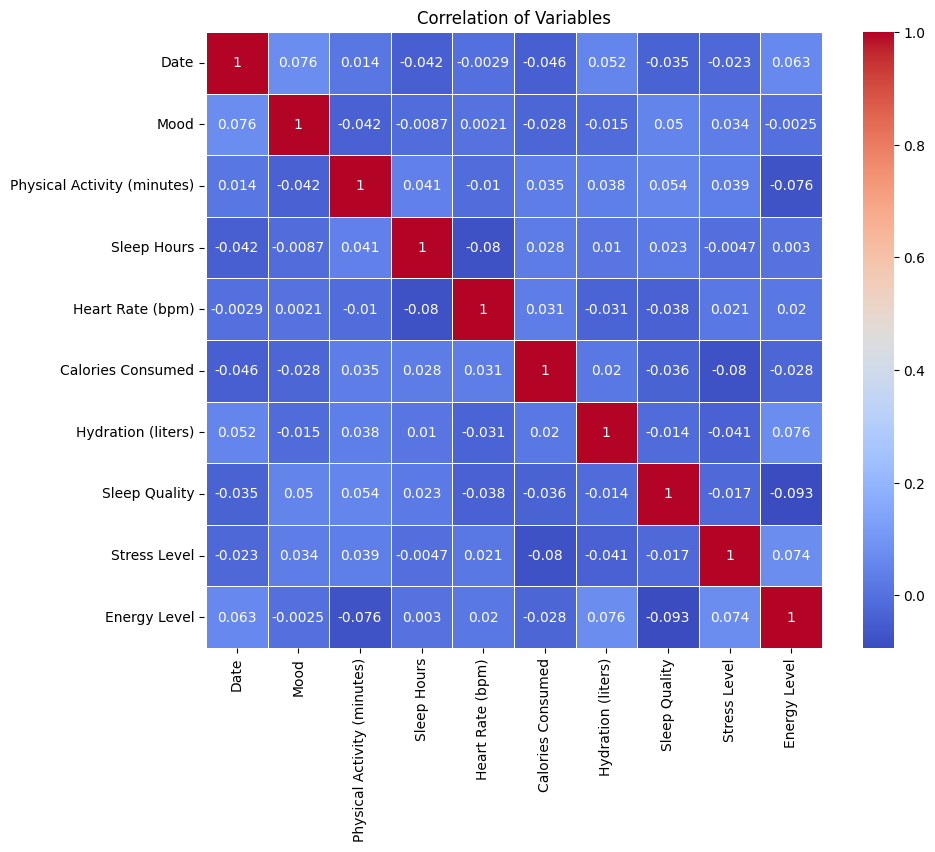

In [26]:
correlation_matrix = df_encoded.drop(columns = ['Day_of_Week','Week_of_Year', 'Month']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation of Variables")
plt.axis('equal')
plt.show()


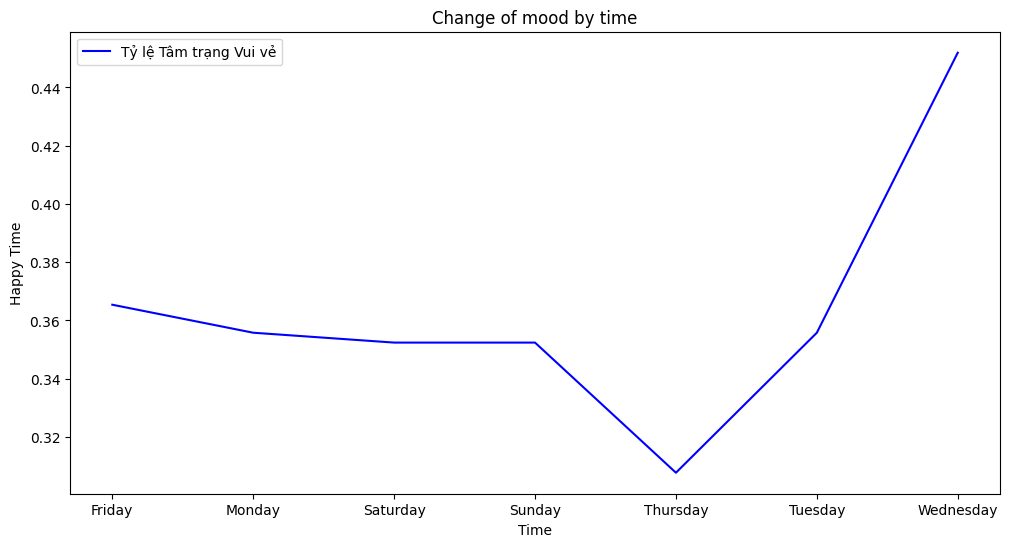

In [33]:
mood_over_time = df_encoded.groupby("Day_of_Week")["Mood"].apply(lambda x: (x == 1).mean())  # Tính tỷ lệ "Happy" theo ngày

plt.figure(figsize=(12, 6))
plt.plot(mood_over_time.index, mood_over_time.values, color='blue', label="Tỷ lệ Tâm trạng Vui vẻ")
plt.xlabel("Time")
plt.ylabel("Happy Time")
plt.title("Change of mood by time")
plt.legend()
plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_9328\3570949478.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=sleep_quality_mood, palette="tab10", linewidth=2.5)


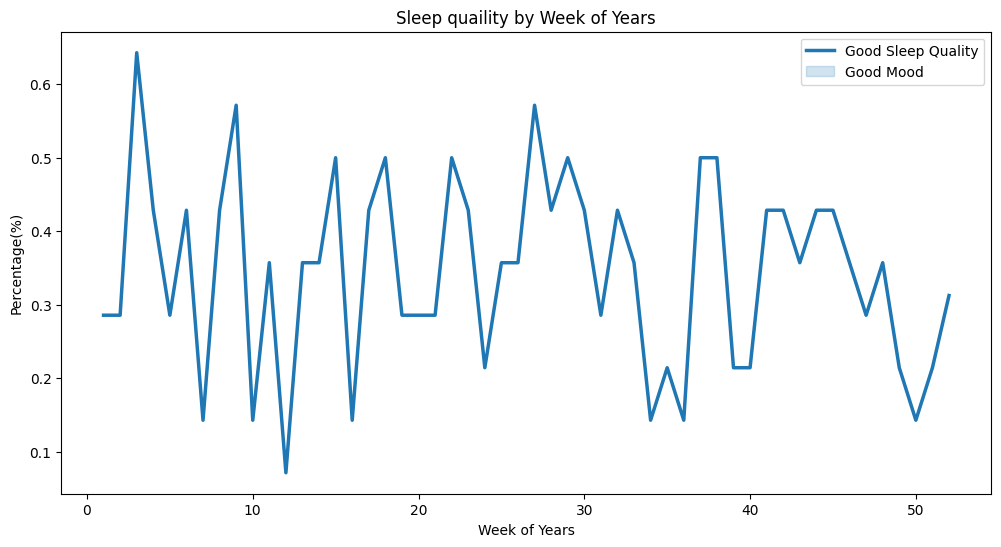

In [34]:
sleep_quality_mood = df_encoded.groupby("Week_of_Year")[["Sleep Quality", "Mood"]].apply(lambda x: (x["Sleep Quality"] == 1).mean())

plt.figure(figsize=(12, 6))
sns.lineplot(data=sleep_quality_mood, palette="tab10", linewidth=2.5)
plt.xlabel("Week of Years")
plt.ylabel("Percentage(%)")
plt.title("Sleep quaility by Week of Years")
plt.legend(["Good Sleep Quality", "Good Mood"])
plt.show()


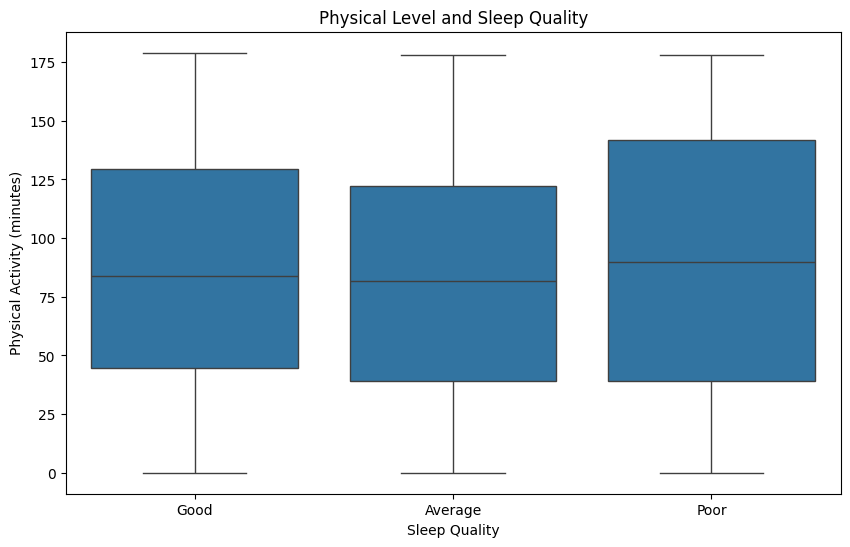

In [31]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="Sleep Quality", y="Physical Activity (minutes)", data=df)
plt.title("Physical Level and Sleep Quality")
plt.show()


# Model

In [32]:
X = df_encoded.drop(["Date", "Mood",'Day_of_Week','Week_of_Year', 'Month'], axis=1)  # Drop non-feature and target columns
y = df_encoded["Mood"]
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=200,class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[42 51]
 [29 24]]

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.45      0.51        93
           1       0.32      0.45      0.38        53

    accuracy                           0.45       146
   macro avg       0.46      0.45      0.44       146
weighted avg       0.49      0.45      0.46       146

